# QFT Application: Hidden Patterns

Suppose we have a four-qubit quantum register containing one of the three states (A, B, or C):

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import math
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_city, plot_histogram
from math import pi

sampler = Sampler()


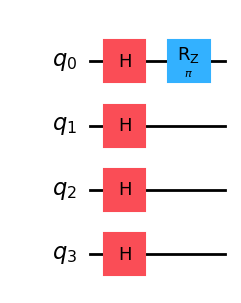

In [18]:
def sig_a():
    A = QuantumCircuit(4, name='prepare A')
    for i in range(4):
        A.h(i)
    A.rz(math.radians(180), 0)
    return A

c = sig_a()
c.draw('mpl')

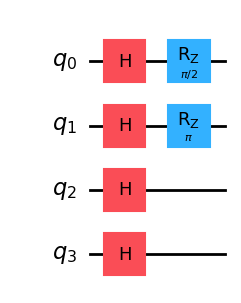

In [19]:
def sig_b():
    B = QuantumCircuit(4, name='prepare B')
    for i in range(4):
        B.h(i)
    B.rz(math.radians(90), 0)
    B.rz(math.radians(180), 1)
    return B

c = sig_b()
c.draw('mpl')

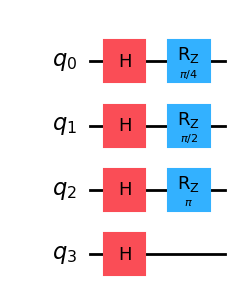

In [20]:
def sig_c():
    C = QuantumCircuit(4, name='C')
    for i in range(4):
        C.h(i)
    C.rz(math.radians(45), 0)
    C.rz(math.radians(90), 1)
    C.rz(math.radians(180), 2)
    return C

c = sig_c()
c.draw('mpl')

Visually we can tell that these states are different from each other:

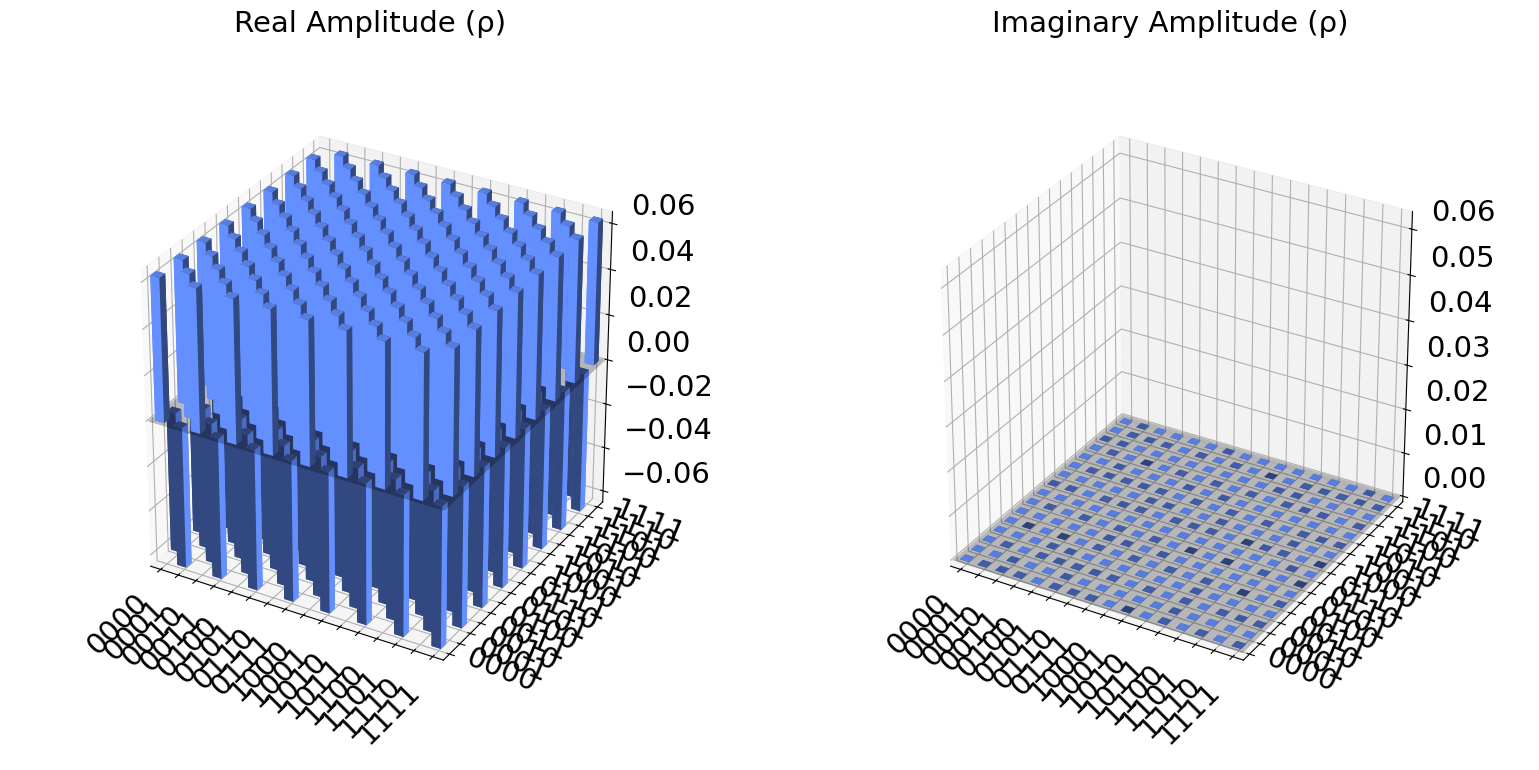

In [5]:
plot_state_city(sig_a())

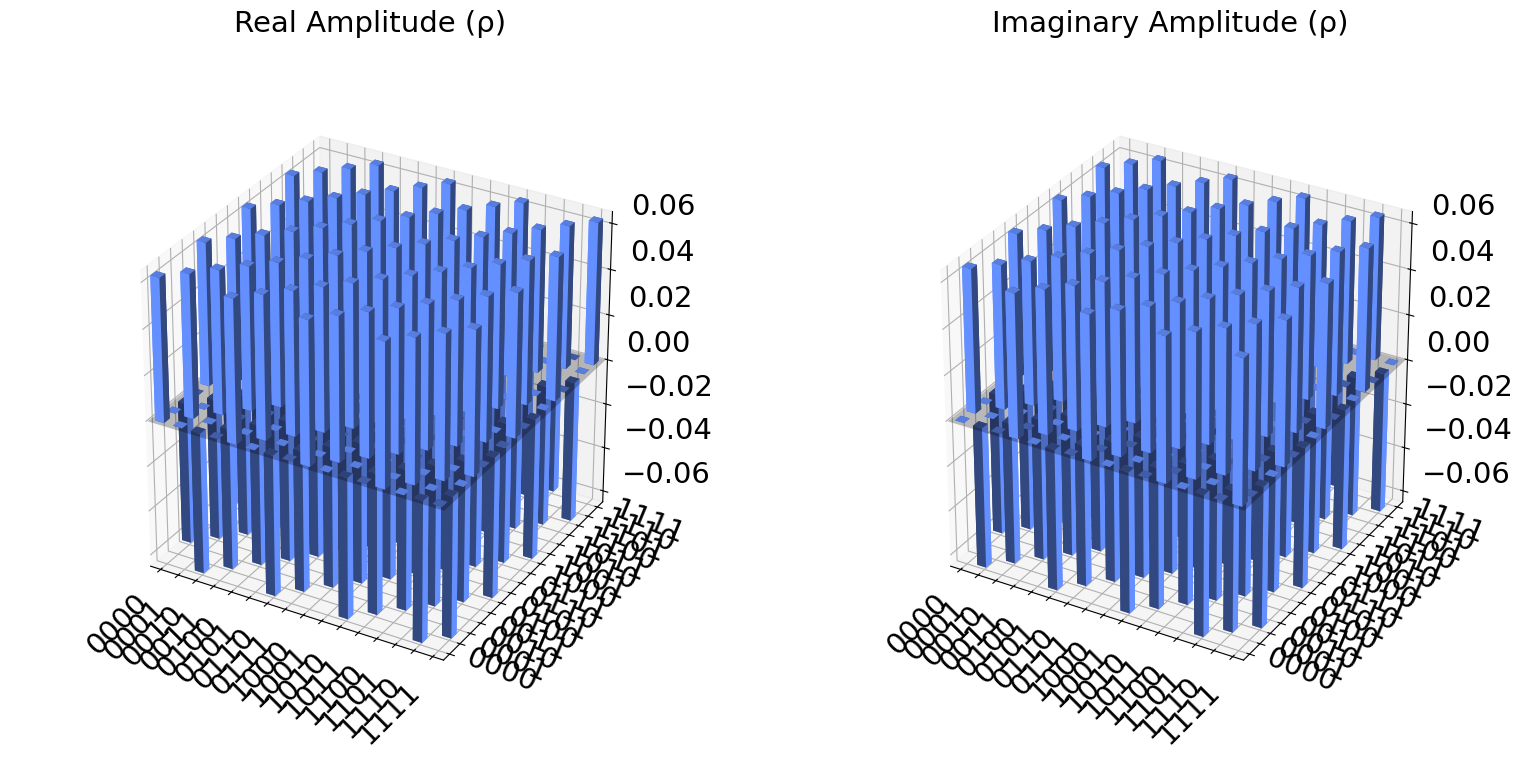

In [6]:
plot_state_city(sig_b())

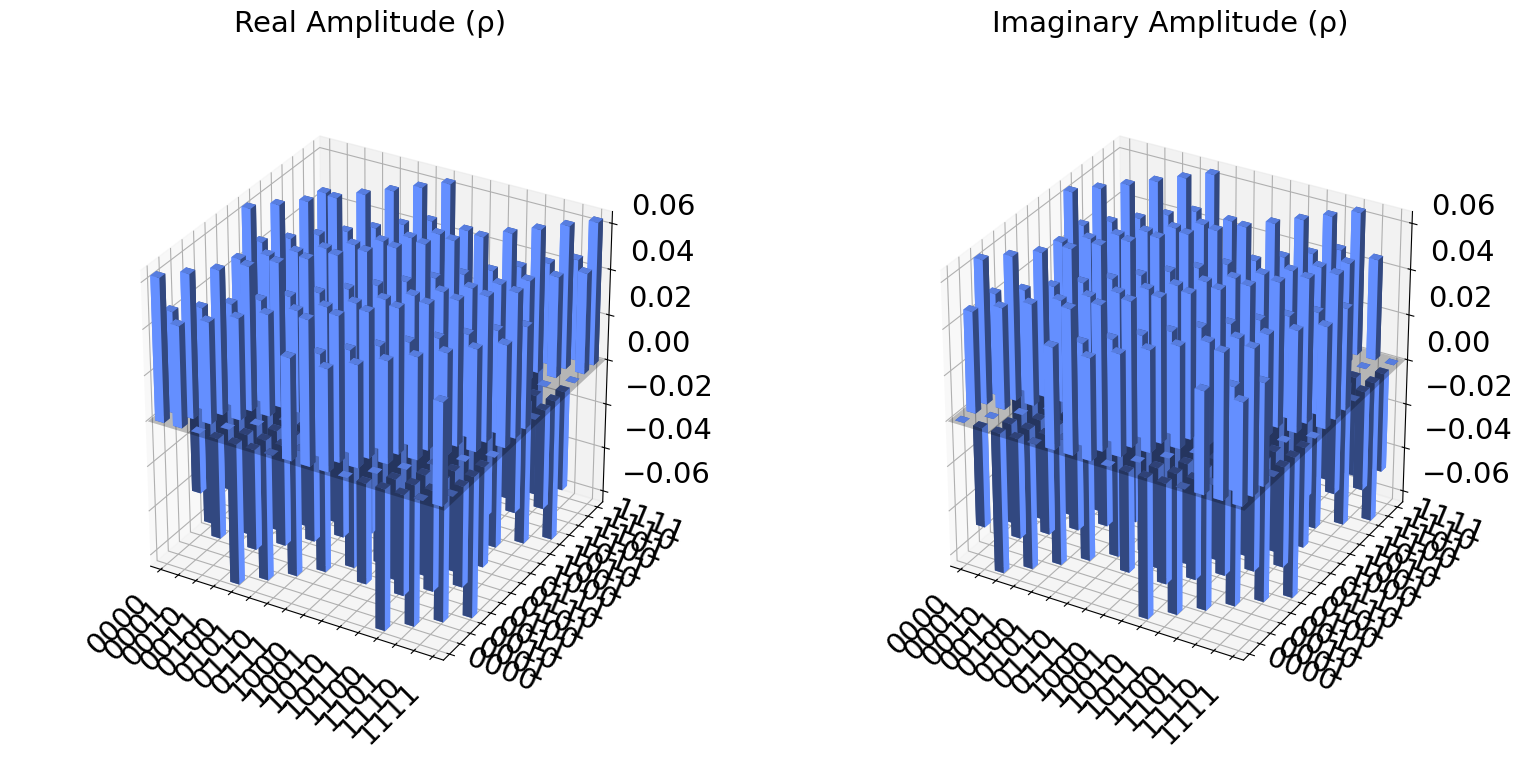

In [7]:
plot_state_city(sig_c())

 since the magnitudes of all values in each of these states are the same, the measurement results returns the same distribution for all three states.

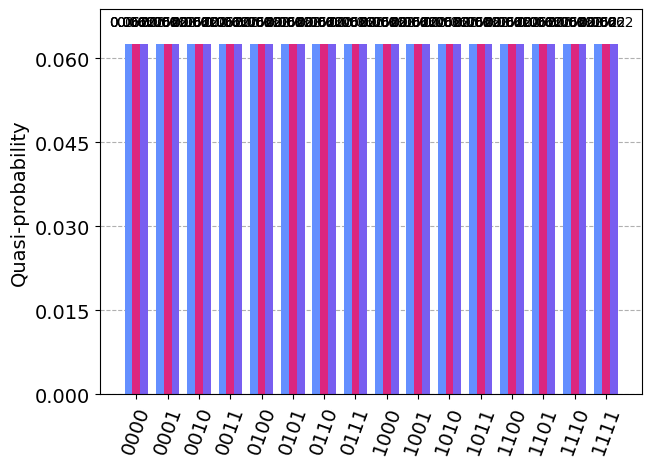

In [8]:

data = []
for sig in [sig_a(), sig_b(), sig_c()]:
    qc = QuantumCircuit(4)
    qc.append(sig, [0,1,2,3])
    qc.measure_all()
    job = sampler.run(qc)
    res = job.result()
    data.append(res.quasi_dists[0].binary_probabilities())

plot_histogram(data)

To distinguish these state we need to use the QFT primitive. 

The QFT results obtained by reading the register allow us to precisely identify the initial state using only a single set of READ operations.

In [9]:

"""
We define the QFT
"""
def QFT(n):
    q = QuantumRegister(n, name='q')
    qc = QuantumCircuit(q, name='QFT')
    # QFT with n qubits
    # First we apply hadamard and control phase gates
    for j in range(n-1,-1,-1):
        qc.h(q[j])
        for k in range(j):
            qc.cp(pi/2**(k+1), q[j-1-k], q[j])
        qc.barrier()
    # Now finish the QFT by reversing the order of the qubits
    for j in range(n//2):
        qc.swap(q[j], q[n-j-1])
        
    return qc

sig_after_qft = []
for sig in [sig_a(), sig_b(), sig_c()]:
    qc = QuantumCircuit(4)
    qc.append(sig, [0,1,2,3])
    qc.append(QFT(4), [0, 1, 2, 3])
    sig_after_qft.append(qc)

In [22]:
sig_after_qft[0].decompose().draw()
sig_after_qft[0].draw()

┌────────────┐┌──────┐
q_0: ┤0           ├┤0     ├
     │            ││      │
q_1: ┤1           ├┤1     ├
     │  prepare B ││  QFT │
q_2: ┤2           ├┤2     ├
     │            ││      │
q_3: ┤3           ├┤3     ├
     └────────────┘└──────┘

In [11]:
sig_after_qft[1].decompose().draw()
sig_after_qft[1].draw()

┌────────────┐┌──────┐
q_0: ┤0           ├┤0     ├
     │            ││      │
q_1: ┤1           ├┤1     ├
     │  prepare B ││  QFT │
q_2: ┤2           ├┤2     ├
     │            ││      │
q_3: ┤3           ├┤3     ├
     └────────────┘└──────┘

In [24]:
sig_after_qft[2].decompose().draw()
# sig_after_qft[2].draw()


┌───┐┌─────────┐                            ░                         ░ »
q_0: ┤ H ├┤ Rz(π/4) ├───────────────────■────────░────────────────■────────░─»
     ├───┤├─────────┤                   │        ░                │        ░ »
q_1: ┤ H ├┤ Rz(π/2) ├──────────■────────┼────────░───────■────────┼────────░─»
     ├───┤└┬───────┬┘          │        │        ░ ┌───┐ │P(π/2)  │P(π/4)  ░ »
q_2: ┤ H ├─┤ Rz(π) ├──■────────┼────────┼────────░─┤ H ├─■────────■────────░─»
     ├───┤ └─┬───┬─┘  │P(π/2)  │P(π/4)  │P(π/8)  ░ └───┘                   ░ »
q_3: ┤ H ├───┤ H ├────■────────■────────■────────░─────────────────────────░─»
     └───┘   └───┘                               ░                         ░ »
«                    ░ ┌───┐ ░       
«q_0: ──────■────────░─┤ H ├─░──X────
«     ┌───┐ │P(π/2)  ░ └───┘ ░  │    
«q_1: ┤ H ├─■────────░───────░──┼──X─
«     └───┘          ░       ░  │  │ 
«q_2: ───────────────░───────░──┼──X─
«                    ░       ░  │    
«q_3: ───────────────░───────░──X────
«                    ░       ░

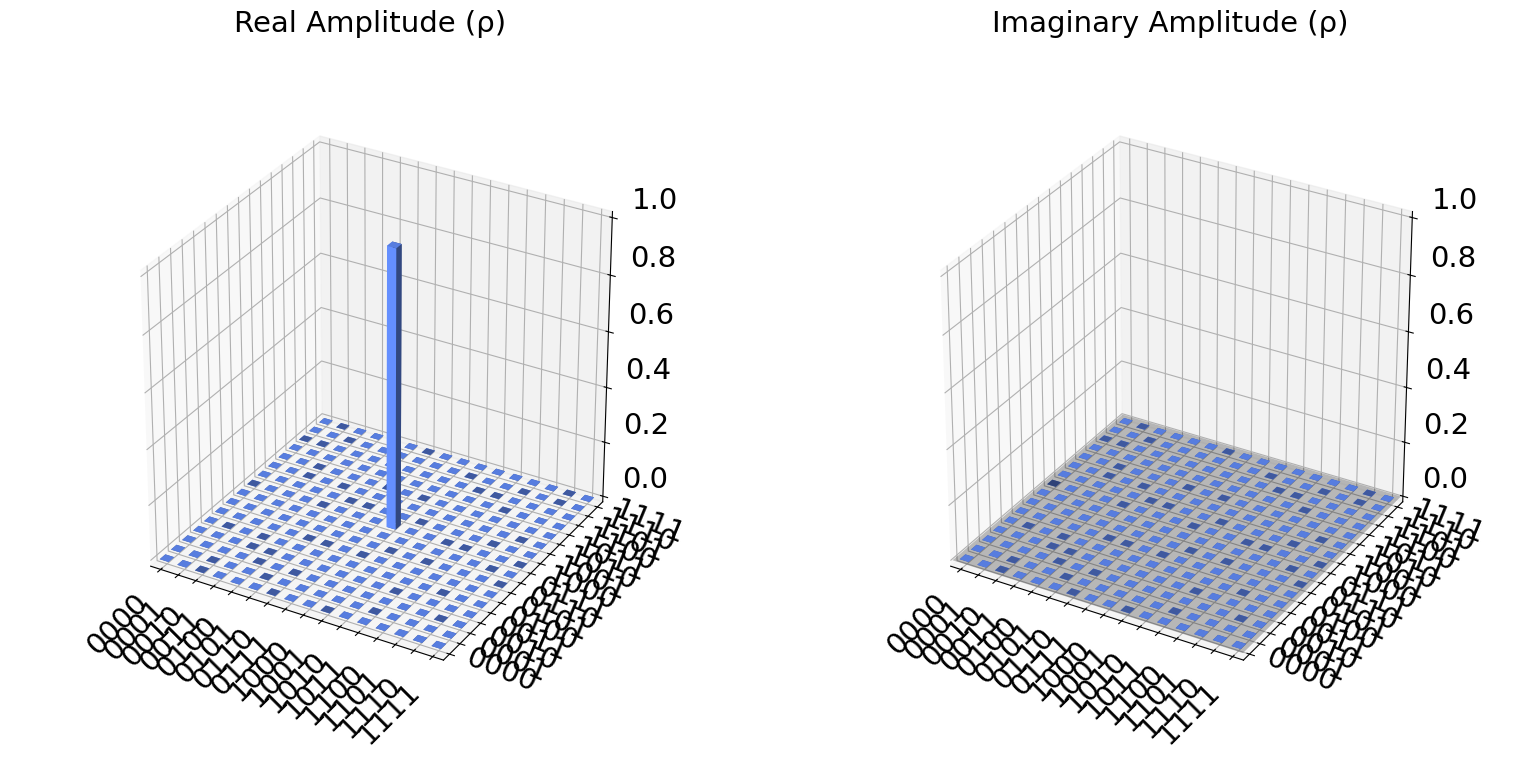

In [13]:
plot_state_city(sig_after_qft[0])

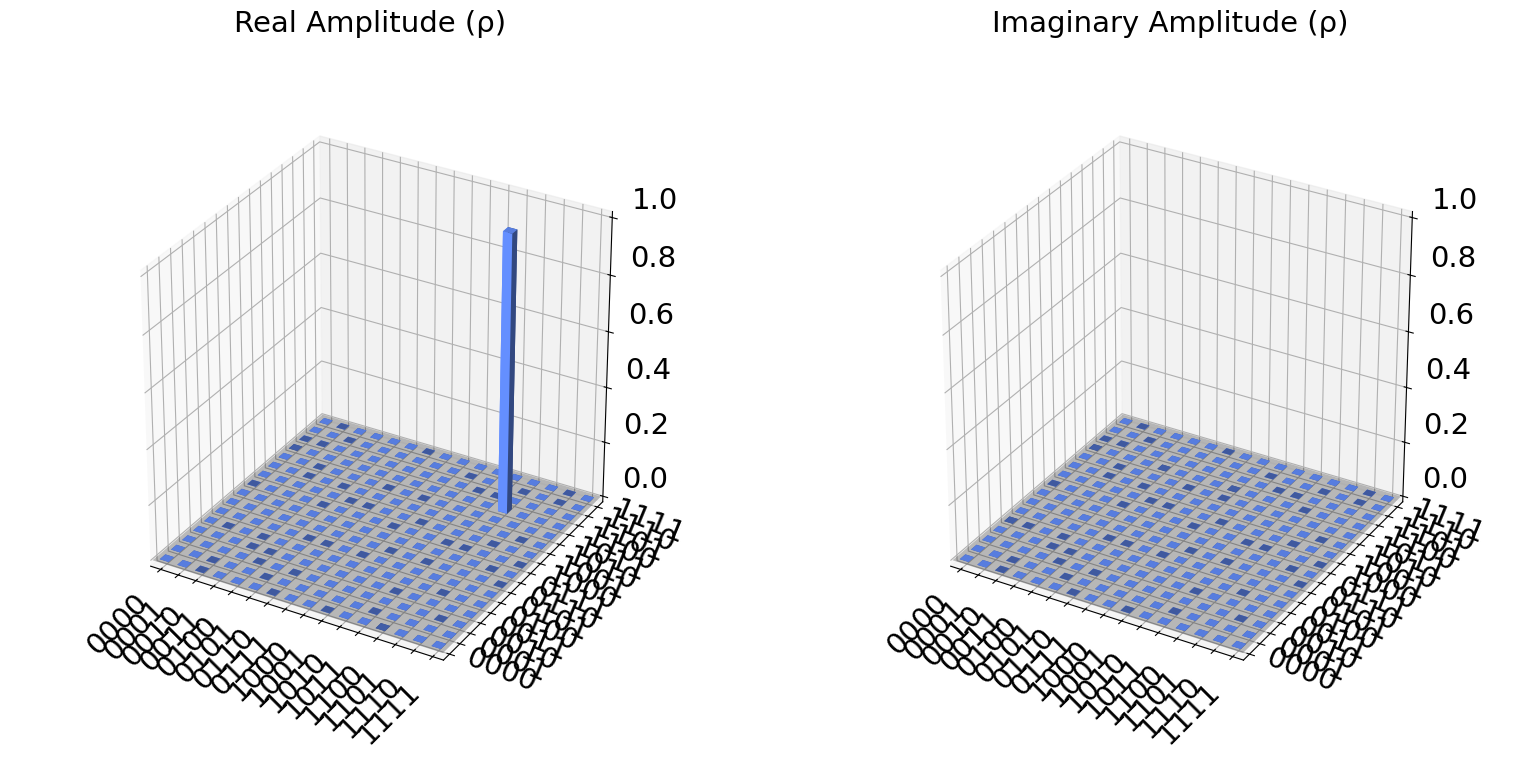

In [14]:
plot_state_city(sig_after_qft[1])

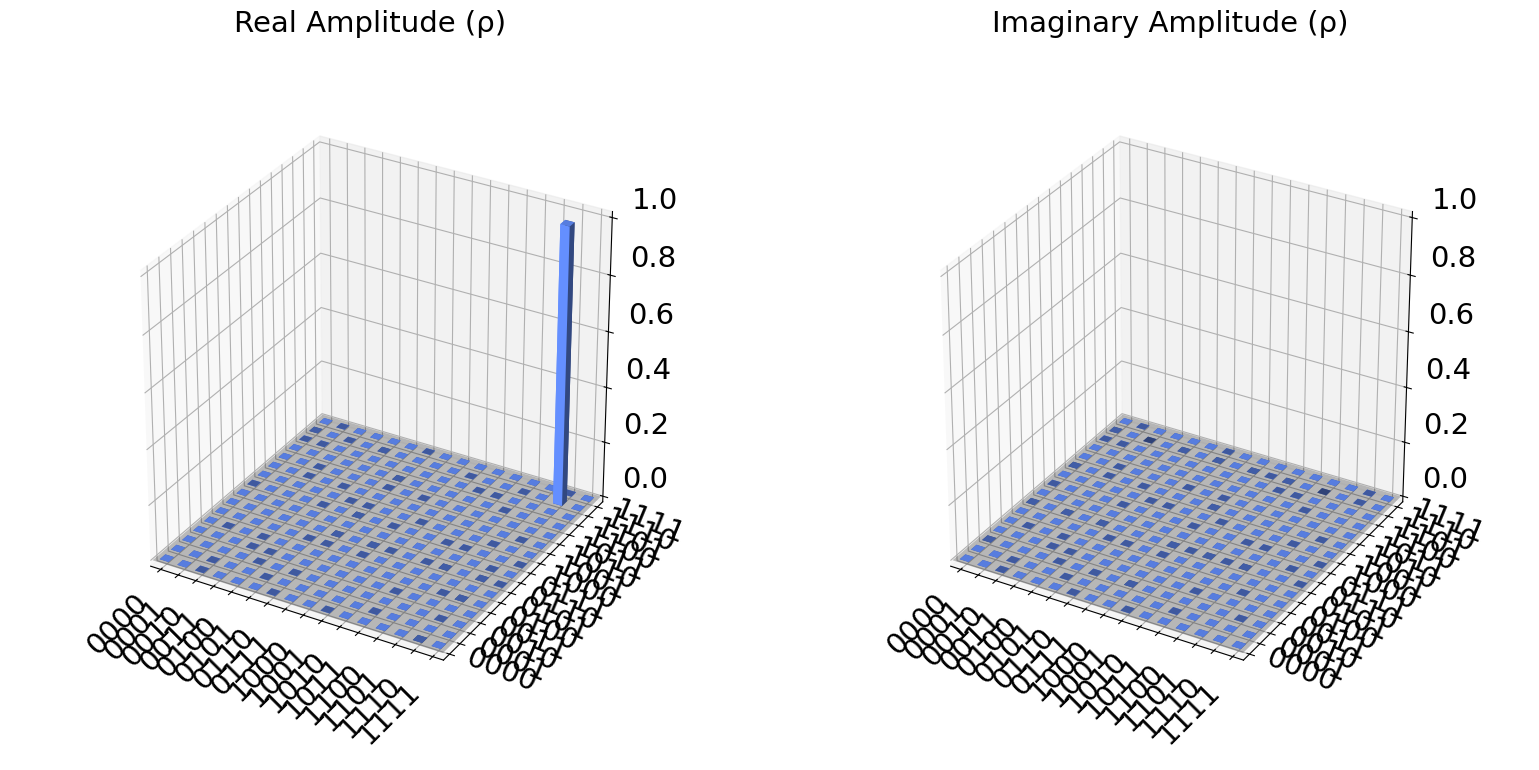

In [15]:
plot_state_city(sig_after_qft[2])

In [16]:
sig_name = ['A', 'B', 'C']

for i in range(len(sig_after_qft)):
    print(sig_name[i],': ')
    outputstate = Statevector(sig_after_qft[i]) # result.get_statevector(qc, decimals=3)
    # print(outputstate)
    for i,amp in enumerate(outputstate):
        #print(i,amp)
        if abs(amp) > 0.000001:
            prob = abs(amp) * abs(amp)
            print('    |{}>, amplitude = {}, probability = {}%'.format(i, amp, round(prob * 100, 5)))


A : 
    |8>, amplitude = -0.9999999999999993j, probability = 100.0%
B : 
    |12>, amplitude = (-0.7071067811865472-0.707106781186547j), probability = 100.0%
C : 
    |14>, amplitude = (-0.9238795325112863-0.38268343236508956j), probability = 100.0%


Also if we measure we obtain the same result

        ┌────────────┐┌──────┐ ░ ┌─┐         
   q_0: ┤0           ├┤0     ├─░─┤M├─────────
        │            ││      │ ░ └╥┘┌─┐      
   q_1: ┤1           ├┤1     ├─░──╫─┤M├──────
        │  prepare A ││  QFT │ ░  ║ └╥┘┌─┐   
   q_2: ┤2           ├┤2     ├─░──╫──╫─┤M├───
        │            ││      │ ░  ║  ║ └╥┘┌─┐
   q_3: ┤3           ├┤3     ├─░──╫──╫──╫─┤M├
        └────────────┘└──────┘ ░  ║  ║  ║ └╥┘
meas: 4/══════════════════════════╩══╩══╩══╩═
                                  0  1  2  3 
        ┌────────────┐┌──────┐ ░ ┌─┐         
   q_0: ┤0           ├┤0     ├─░─┤M├─────────
        │            ││      │ ░ └╥┘┌─┐      
   q_1: ┤1           ├┤1     ├─░──╫─┤M├──────
        │  prepare B ││  QFT │ ░  ║ └╥┘┌─┐   
   q_2: ┤2           ├┤2     ├─░──╫──╫─┤M├───
        │            ││      │ ░  ║  ║ └╥┘┌─┐
   q_3: ┤3           ├┤3     ├─░──╫──╫──╫─┤M├
        └────────────┘└──────┘ ░  ║  ║  ║ └╥┘
meas: 4/══════════════════════════╩══╩══╩══╩═
                                  

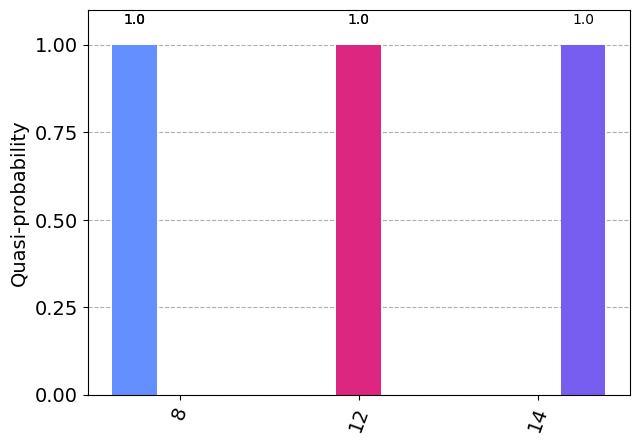

In [25]:
data = []
for sig in sig_after_qft:
    qc = sig.copy()
    qc.measure_all()
    print(qc.draw())
    job = sampler.run(qc)
    res = job.result()
    data.append(res.quasi_dists[0])

plot_histogram(data)

After having adding the QFT, we can check the state of our tree signal

#### Homework
Study and implement the *Signal processing with the QFT*, described in the book:

**Programming Quantum Computers** *(Johnston, E. R.; Harrigan, N.; Gimeno-Segovia, M.)*.

in chapter 7 (page 141).

In particular, pay attention to the **inverse QFT**.
In the book, you can find the link to the implementation of the examples in Qiskit so you can check your solution (the solution is in Qiskit's old version, so the simulation part is different!!)

It could be very useful for implementing inverse QFT, so try it on your own (there is a lot of material on the web).

